In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision.utils import make_grid
# import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import math
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

In [2]:
df = pd.read_csv("train.csv")

In [3]:
len(df)

42000

In [4]:
df['label'].value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

In [5]:
# Find the maximum number of occurrences of any digit
max_size = df['label'].value_counts().max()

# Use pd.concat to create a list of dataframes to be concatenated
frames = [df]  # Start with the original dataframe

# Loop through each class group and append necessary duplicates
for class_index, group in df.groupby('label'):
    samples_to_add = max_size - len(group)
    if samples_to_add > 0:
        frames.append(group.sample(samples_to_add, replace=True))

# Concatenate all the frames together and shuffle the dataframe
df = pd.concat(frames).sample(frac=1).reset_index(drop=True)

# Check the new value counts to confirm balancing
print(df['label'].value_counts())

label
5    4684
4    4684
2    4684
3    4684
1    4684
0    4684
7    4684
8    4684
6    4684
9    4684
Name: count, dtype: int64


In [6]:
# 1 represents real, 0 fake
df['label'] = 1

In [7]:
X_discriminator = df.drop('label', axis=1)
y_discriminator = torch.tensor(df['label'].values, dtype=torch.float32)

In [8]:
pixel_columns = df.shape[1] - 1  # subtracting 1 for the label column

image_side_length = int(pixel_columns**0.5)
print(f"Each image is {image_side_length}x{image_side_length} pixels.")

Each image is 28x28 pixels.


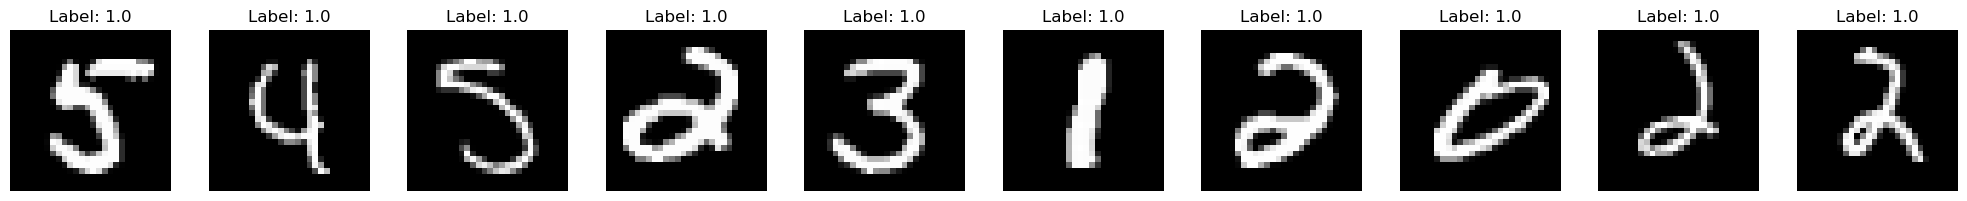

In [9]:
fig, axes = plt.subplots(1, 10, figsize=(20, 2))  
for i, ax in enumerate(axes):
    # Reshape each row into 28x28 array and plot
    img = X_discriminator.iloc[i].to_numpy().reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {y_discriminator[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [10]:
X_discriminator = X_discriminator.values.reshape(-1, 1, 28, 28)
X_discriminator = (torch.tensor(X_discriminator).float() / 255.0) * 2 - 1

In [11]:
dataset_discriminator = TensorDataset(X_discriminator, y_discriminator)
loader_discriminator = DataLoader(dataset_discriminator, batch_size=64, shuffle=True)

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(in_features=128*7*7, out_features=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))

        x = F.relu(self.conv6(x))
        x = x.view(-1, 128*7*7)
        x = self.dropout(x)
        x = self.fc(x)
        return torch.sigmoid(x)

In [13]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(in_features=noise_dim, out_features=noise_dim) # (1, 49) -> (1, 7, 7)
        self.convT1 = nn.ConvTranspose2d(in_channels=1, out_channels=128, kernel_size=4, stride=1)  # (1, 7, 7) -> (1, 10, 10)
        self.bn1 = nn.BatchNorm2d(num_features=128)
        self.convT2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2) # (1, 10, 10) -> (1, 22, 22)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.convT3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1) # (1, 22, 22) -> (1, 24, 24)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.convT4 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1) # (1, 24, 24) -> (1, 26, 26)
        self.bn4 = nn.BatchNorm2d(num_features=16)
        # self.dropout = nn.Dropout(0.3)
        self.convT5 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1) # (1, 26, 26) -> (1, 28, 28)

    def forward(self, x):
        x = F.leaky_relu(self.fc(x))
        x = x.view(-1, 1, int(math.sqrt(noise_dim)), int(math.sqrt(noise_dim)))
        x = F.relu(self.bn1(self.convT1(x)))
        x = F.relu(self.bn2(self.convT2(x)))
        x = F.relu(self.bn3(self.convT3(x)))
        x = F.relu(self.bn4(self.convT4(x)))
        # x = self.dropout(x)
        x = torch.tanh(self.convT5(x))
        return x

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

noise_dim = 49
generator = Generator(noise_dim=noise_dim).to(device)
discriminator = Discriminator().to(device)

optim_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
scheduler_G = StepLR(optimizer=optim_G, step_size=10, gamma=0.8)
scheduler_D = StepLR(optimizer=optim_D, step_size=10, gamma=0.8)

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.79it/s, loss_D=1.15, loss_G=0.899]


Epoch [1/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [1/100] - Average D loss: 1.2572, Average G loss: 0.8574


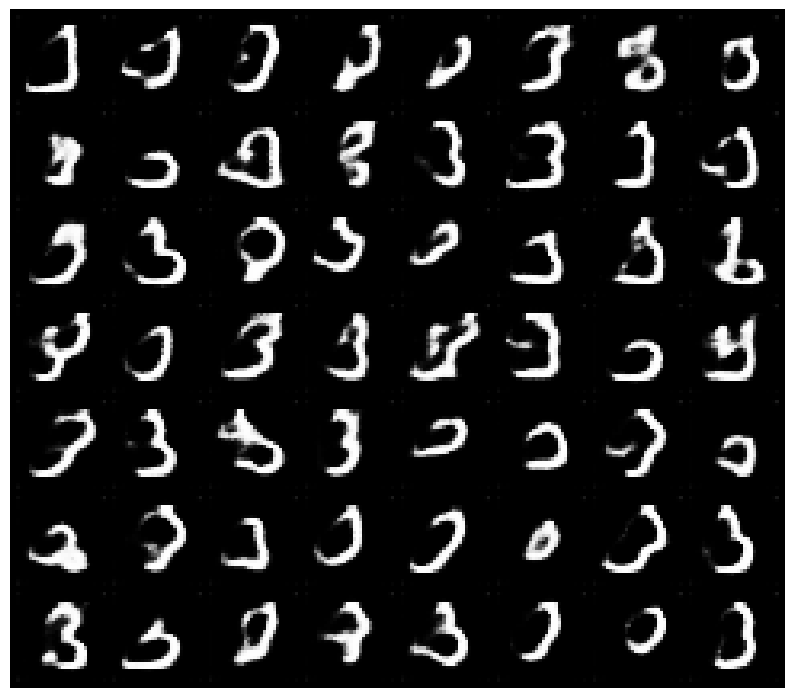

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.30it/s, loss_D=1.08, loss_G=0.859]


Epoch [2/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [2/100] - Average D loss: 1.1933, Average G loss: 0.9630


100%|██████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.30it/s, loss_D=1.11, loss_G=1.08]


Epoch [3/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [3/100] - Average D loss: 1.1354, Average G loss: 1.0068


100%|██████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.24it/s, loss_D=0.95, loss_G=1.01]


Epoch [4/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [4/100] - Average D loss: 1.0350, Average G loss: 1.1847


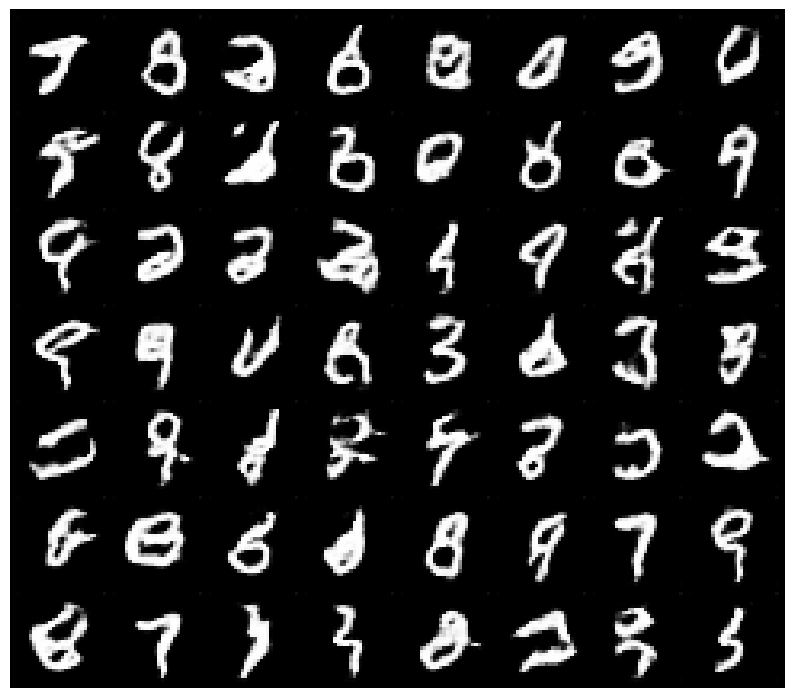

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.07it/s, loss_D=0.916, loss_G=1.09]


Epoch [5/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [5/100] - Average D loss: 0.9557, Average G loss: 1.3344


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.17it/s, loss_D=0.925, loss_G=2.08]


Epoch [6/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [6/100] - Average D loss: 0.8699, Average G loss: 1.5140


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.00it/s, loss_D=0.772, loss_G=1.53]


Epoch [7/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [7/100] - Average D loss: 0.8231, Average G loss: 1.6296


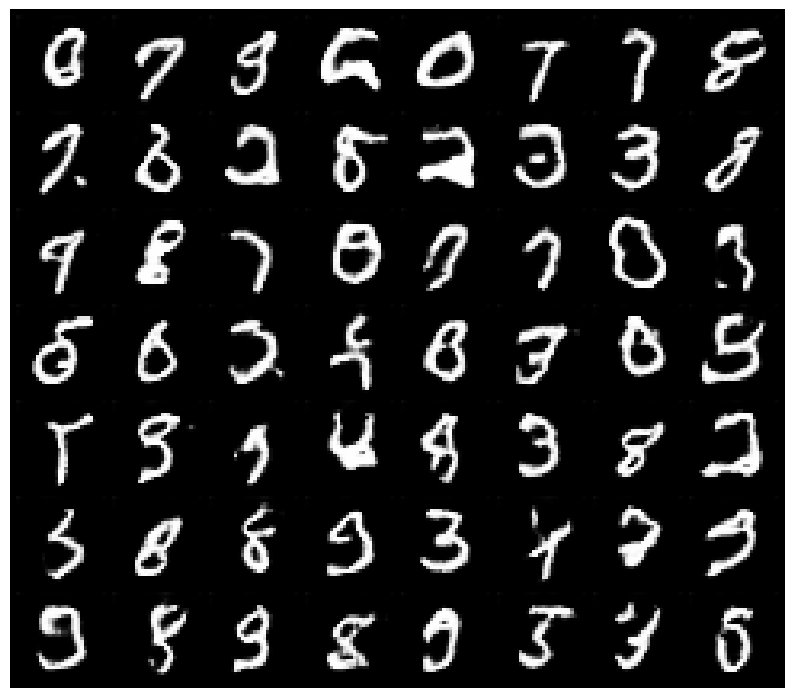

100%|██████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.13it/s, loss_D=0.816, loss_G=1.8]


Epoch [8/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [8/100] - Average D loss: 0.7953, Average G loss: 1.7089


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.13it/s, loss_D=0.889, loss_G=2.41]


Epoch [9/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [9/100] - Average D loss: 0.7804, Average G loss: 1.7579


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.35it/s, loss_D=0.744, loss_G=1.45]


Epoch [10/100] - LR G: 0.0001600, LR D: 0.0001600
Epoch [10/100] - Average D loss: 0.7888, Average G loss: 1.7606


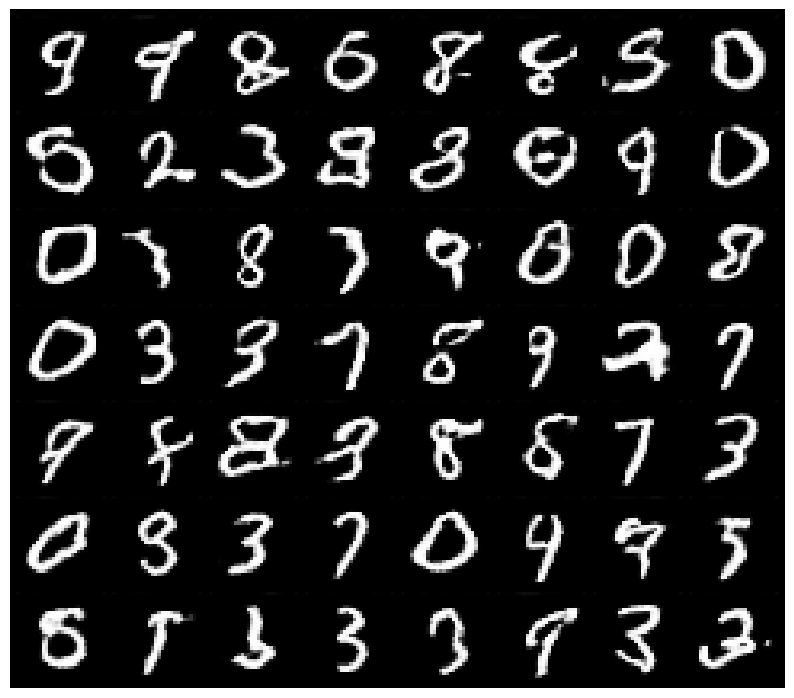

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.21it/s, loss_D=0.822, loss_G=1.23]


Epoch [11/100] - LR G: 0.0001600, LR D: 0.0001600
Epoch [11/100] - Average D loss: 0.7487, Average G loss: 1.8260


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.23it/s, loss_D=0.691, loss_G=1.58]


Epoch [12/100] - LR G: 0.0001600, LR D: 0.0001600
Epoch [12/100] - Average D loss: 0.7427, Average G loss: 1.8571


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.21it/s, loss_D=0.753, loss_G=1.86]


Epoch [13/100] - LR G: 0.0001600, LR D: 0.0001600
Epoch [13/100] - Average D loss: 0.7399, Average G loss: 1.8544


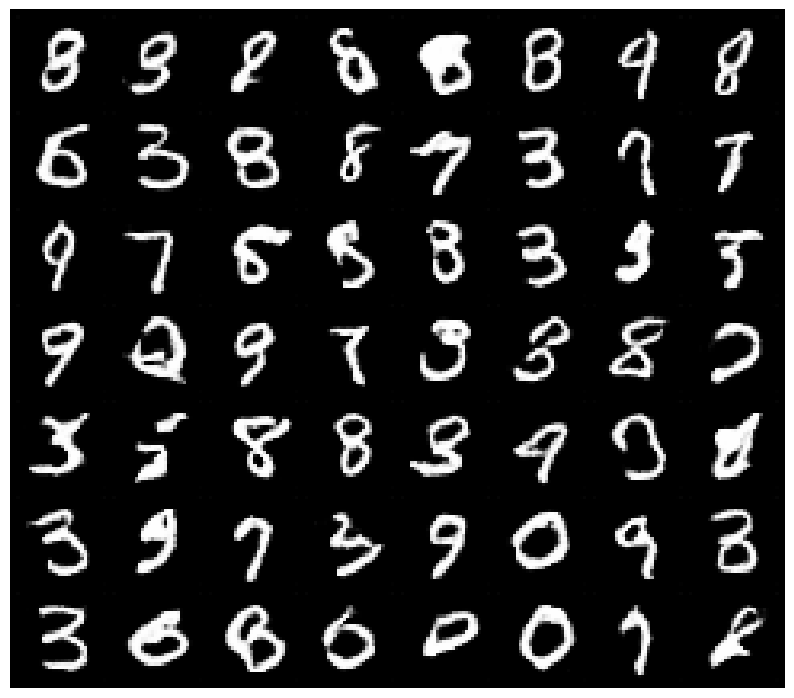

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.13it/s, loss_D=0.503, loss_G=1.89]


Epoch [14/100] - LR G: 0.0001600, LR D: 0.0001600
Epoch [14/100] - Average D loss: 0.7347, Average G loss: 1.8763


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.25it/s, loss_D=0.801, loss_G=1.59]


Epoch [15/100] - LR G: 0.0001600, LR D: 0.0001600
Epoch [15/100] - Average D loss: 0.7168, Average G loss: 1.9345


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.20it/s, loss_D=0.621, loss_G=1.92]


Epoch [16/100] - LR G: 0.0001600, LR D: 0.0001600
Epoch [16/100] - Average D loss: 0.7176, Average G loss: 1.9117


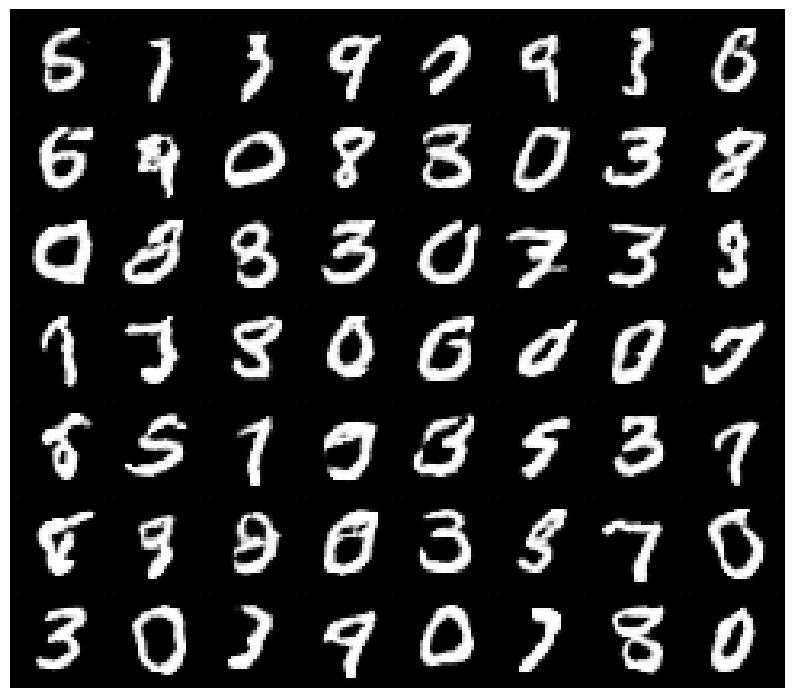

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.92it/s, loss_D=0.715, loss_G=2.05]


Epoch [17/100] - LR G: 0.0001600, LR D: 0.0001600
Epoch [17/100] - Average D loss: 0.7198, Average G loss: 1.9339


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.26it/s, loss_D=0.894, loss_G=2.83]


Epoch [18/100] - LR G: 0.0001600, LR D: 0.0001600
Epoch [18/100] - Average D loss: 0.7154, Average G loss: 1.9358


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.04it/s, loss_D=0.744, loss_G=1.89]


Epoch [19/100] - LR G: 0.0001600, LR D: 0.0001600
Epoch [19/100] - Average D loss: 0.7142, Average G loss: 1.9499


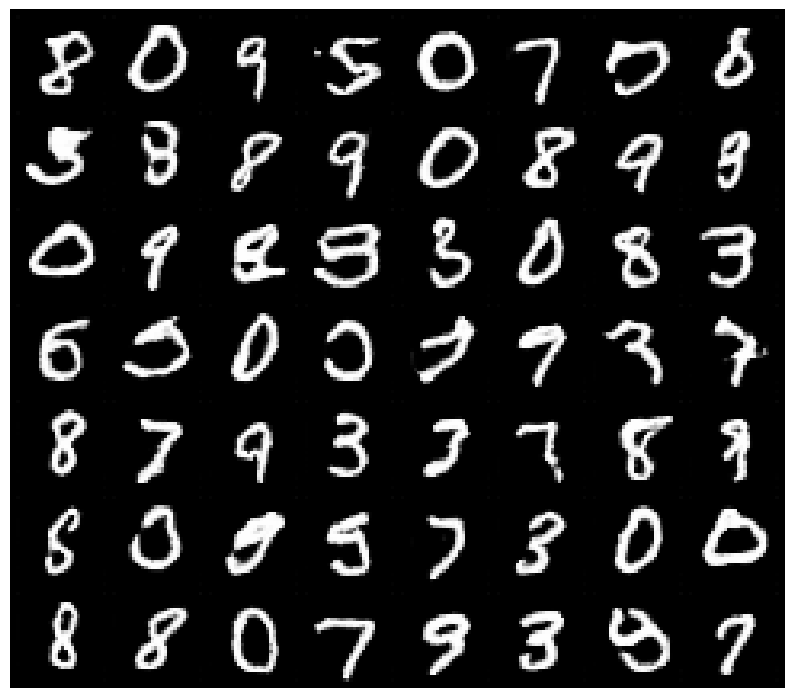

100%|██████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.17it/s, loss_D=0.81, loss_G=2.43]


Epoch [20/100] - LR G: 0.0001280, LR D: 0.0001280
Epoch [20/100] - Average D loss: 0.7007, Average G loss: 1.9727


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.24it/s, loss_D=0.469, loss_G=1.84]


Epoch [21/100] - LR G: 0.0001280, LR D: 0.0001280
Epoch [21/100] - Average D loss: 0.6824, Average G loss: 1.9648


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.20it/s, loss_D=0.691, loss_G=1.88]


Epoch [22/100] - LR G: 0.0001280, LR D: 0.0001280
Epoch [22/100] - Average D loss: 0.6824, Average G loss: 1.9838


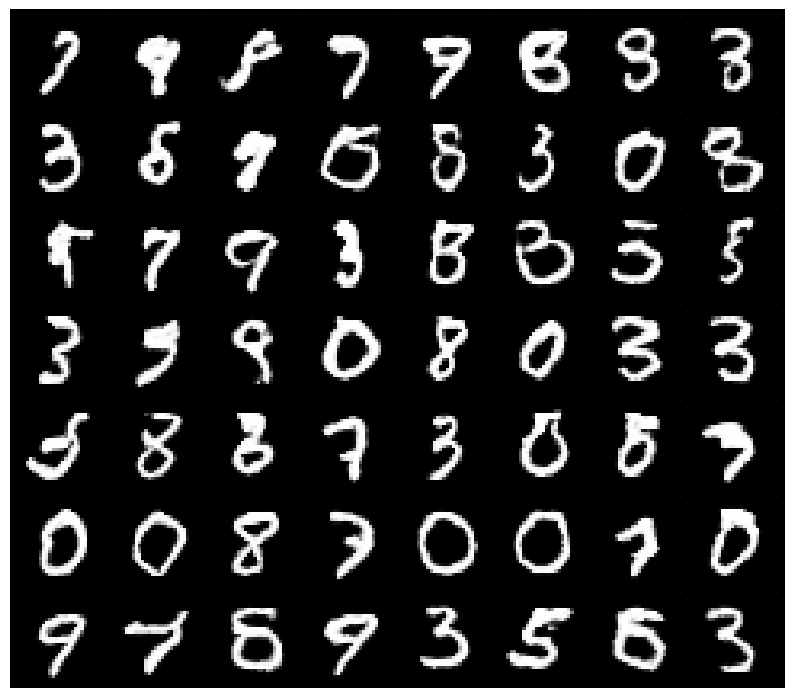

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.13it/s, loss_D=0.523, loss_G=1.96]


Epoch [23/100] - LR G: 0.0001280, LR D: 0.0001280
Epoch [23/100] - Average D loss: 0.6777, Average G loss: 1.9806


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.11it/s, loss_D=0.668, loss_G=1.95]


Epoch [24/100] - LR G: 0.0001280, LR D: 0.0001280
Epoch [24/100] - Average D loss: 0.6758, Average G loss: 2.0131


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.05it/s, loss_D=0.545, loss_G=2.33]


Epoch [25/100] - LR G: 0.0001280, LR D: 0.0001280
Epoch [25/100] - Average D loss: 0.6659, Average G loss: 1.9965


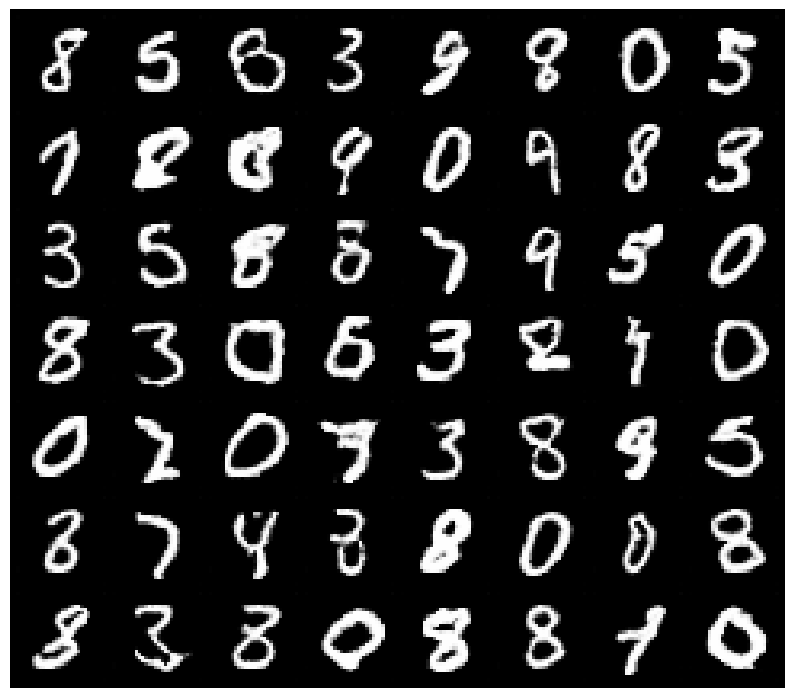

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.09it/s, loss_D=0.584, loss_G=2.35]


Epoch [26/100] - LR G: 0.0001280, LR D: 0.0001280
Epoch [26/100] - Average D loss: 0.6642, Average G loss: 2.0259


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.90it/s, loss_D=0.769, loss_G=1.69]


Epoch [27/100] - LR G: 0.0001280, LR D: 0.0001280
Epoch [27/100] - Average D loss: 0.6659, Average G loss: 2.0055


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.00it/s, loss_D=0.654, loss_G=2.03]


Epoch [28/100] - LR G: 0.0001280, LR D: 0.0001280
Epoch [28/100] - Average D loss: 0.6608, Average G loss: 2.0220


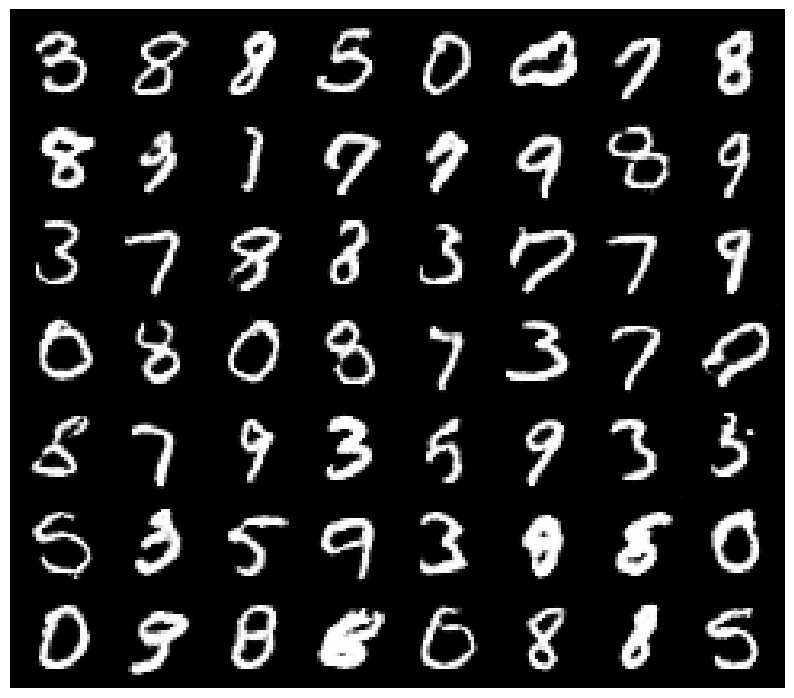

100%|████████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.25it/s, loss_D=0.621, loss_G=2]


Epoch [29/100] - LR G: 0.0001280, LR D: 0.0001280
Epoch [29/100] - Average D loss: 0.6612, Average G loss: 2.0204


100%|█████████████████████████████████████████████████████| 732/732 [00:50<00:00, 14.36it/s, loss_D=0.644, loss_G=2.14]


Epoch [30/100] - LR G: 0.0001024, LR D: 0.0001024
Epoch [30/100] - Average D loss: 0.6569, Average G loss: 2.0240


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.22it/s, loss_D=0.724, loss_G=1.78]


Epoch [31/100] - LR G: 0.0001024, LR D: 0.0001024
Epoch [31/100] - Average D loss: 0.6577, Average G loss: 2.0168


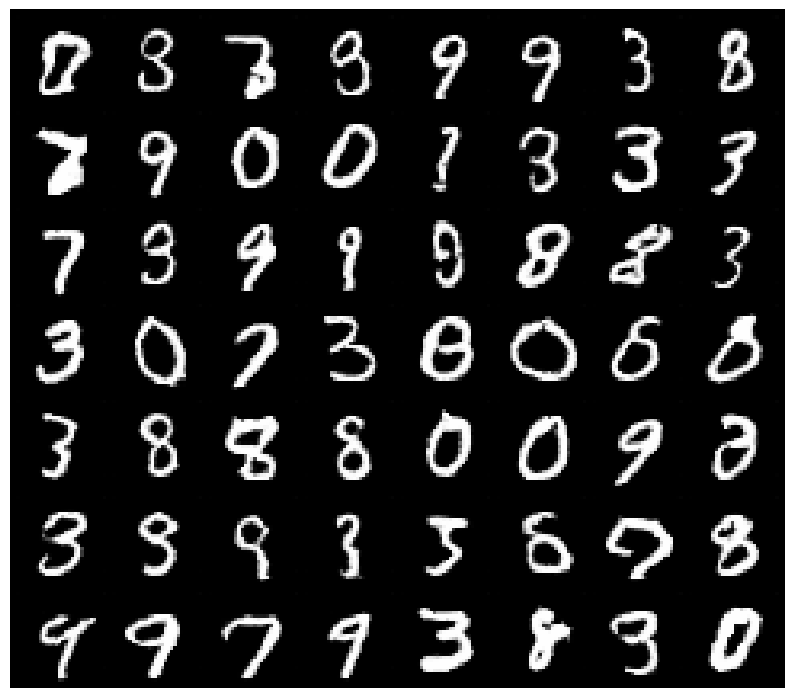

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.12it/s, loss_D=0.621, loss_G=2.43]


Epoch [32/100] - LR G: 0.0001024, LR D: 0.0001024
Epoch [32/100] - Average D loss: 0.6544, Average G loss: 2.0375


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.05it/s, loss_D=0.785, loss_G=2.41]


Epoch [33/100] - LR G: 0.0001024, LR D: 0.0001024
Epoch [33/100] - Average D loss: 0.6575, Average G loss: 2.0176


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.30it/s, loss_D=0.834, loss_G=2.27]


Epoch [34/100] - LR G: 0.0001024, LR D: 0.0001024
Epoch [34/100] - Average D loss: 0.6568, Average G loss: 2.0245


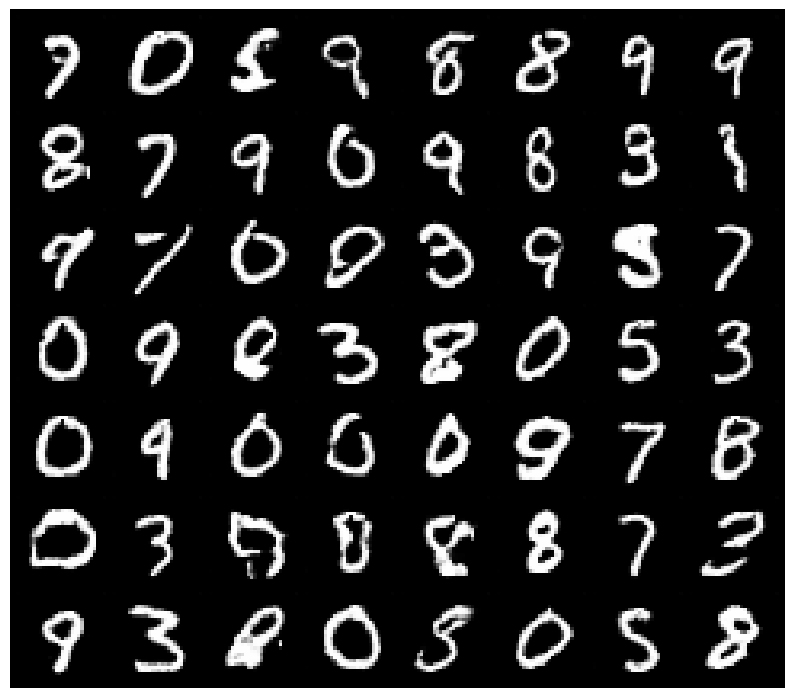

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.00it/s, loss_D=0.676, loss_G=1.65]


Epoch [35/100] - LR G: 0.0001024, LR D: 0.0001024
Epoch [35/100] - Average D loss: 0.6553, Average G loss: 2.0232


100%|████████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.15it/s, loss_D=0.561, loss_G=2]


Epoch [36/100] - LR G: 0.0001024, LR D: 0.0001024
Epoch [36/100] - Average D loss: 0.6525, Average G loss: 2.0256


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.98it/s, loss_D=0.639, loss_G=1.85]


Epoch [37/100] - LR G: 0.0001024, LR D: 0.0001024
Epoch [37/100] - Average D loss: 0.6524, Average G loss: 2.0231


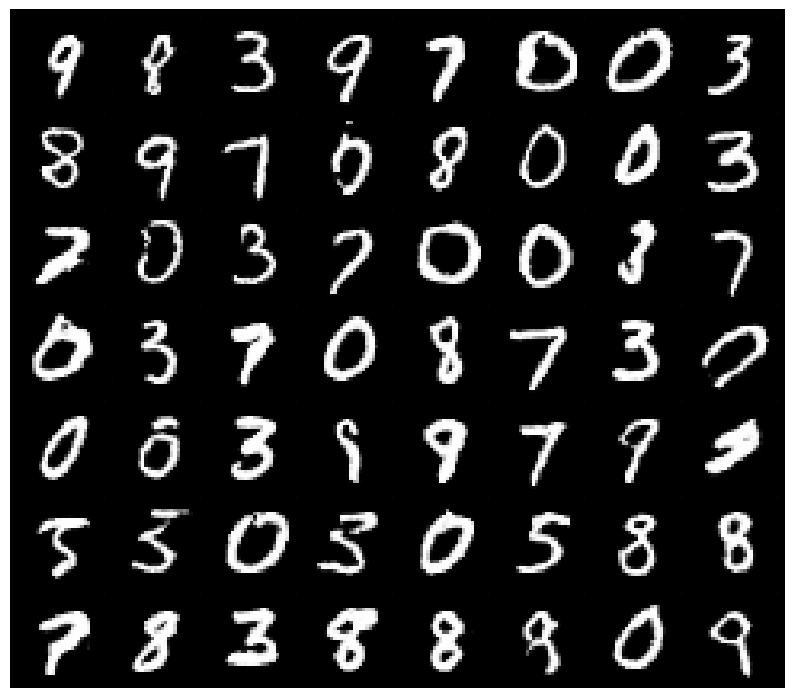

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.24it/s, loss_D=0.822, loss_G=1.75]


Epoch [38/100] - LR G: 0.0001024, LR D: 0.0001024
Epoch [38/100] - Average D loss: 0.6505, Average G loss: 2.0294


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.04it/s, loss_D=0.721, loss_G=1.92]


Epoch [39/100] - LR G: 0.0001024, LR D: 0.0001024
Epoch [39/100] - Average D loss: 0.6535, Average G loss: 2.0111


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.00it/s, loss_D=0.676, loss_G=1.46]


Epoch [40/100] - LR G: 0.0000819, LR D: 0.0000819
Epoch [40/100] - Average D loss: 0.6511, Average G loss: 2.0289


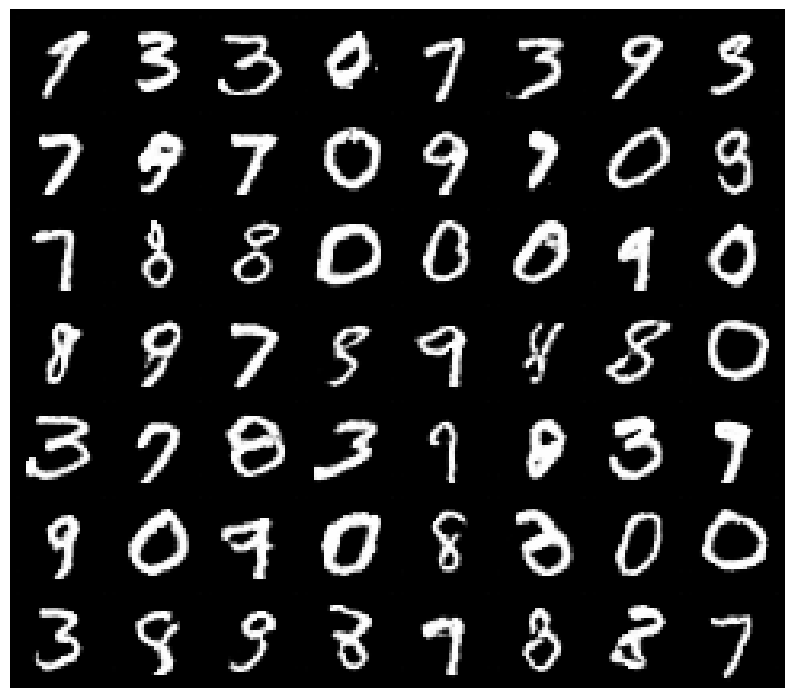

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.15it/s, loss_D=0.619, loss_G=2.08]


Epoch [41/100] - LR G: 0.0000819, LR D: 0.0000819
Epoch [41/100] - Average D loss: 0.6502, Average G loss: 2.0088


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.02it/s, loss_D=0.537, loss_G=1.96]


Epoch [42/100] - LR G: 0.0000819, LR D: 0.0000819
Epoch [42/100] - Average D loss: 0.6457, Average G loss: 2.0183


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.86it/s, loss_D=0.68, loss_G=1.77]


Epoch [43/100] - LR G: 0.0000819, LR D: 0.0000819
Epoch [43/100] - Average D loss: 0.6476, Average G loss: 2.0237


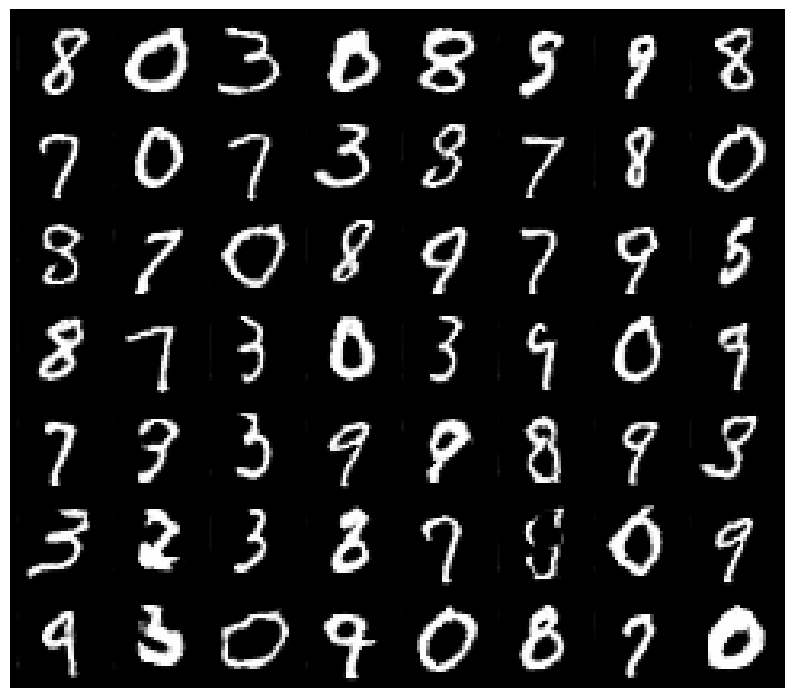

100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.05it/s, loss_D=0.67, loss_G=2.15]


Epoch [44/100] - LR G: 0.0000819, LR D: 0.0000819
Epoch [44/100] - Average D loss: 0.6488, Average G loss: 2.0122


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.01it/s, loss_D=0.605, loss_G=1.97]


Epoch [45/100] - LR G: 0.0000819, LR D: 0.0000819
Epoch [45/100] - Average D loss: 0.6481, Average G loss: 2.0110


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.13it/s, loss_D=0.656, loss_G=1.97]


Epoch [46/100] - LR G: 0.0000819, LR D: 0.0000819
Epoch [46/100] - Average D loss: 0.6470, Average G loss: 2.0259


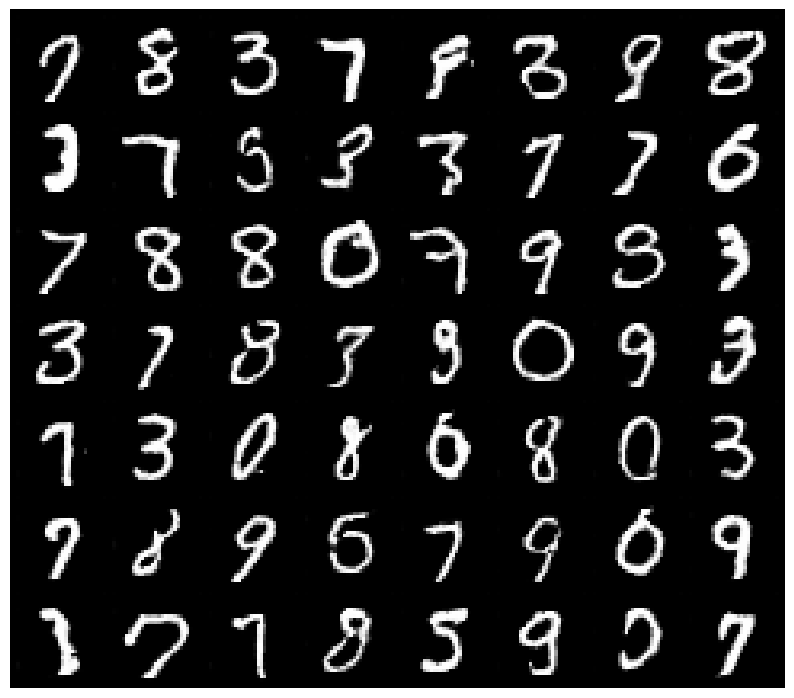

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.17it/s, loss_D=0.772, loss_G=2.18]


Epoch [47/100] - LR G: 0.0000819, LR D: 0.0000819
Epoch [47/100] - Average D loss: 0.6480, Average G loss: 2.0035


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.90it/s, loss_D=0.747, loss_G=1.8]


Epoch [48/100] - LR G: 0.0000819, LR D: 0.0000819
Epoch [48/100] - Average D loss: 0.6500, Average G loss: 2.0232


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.96it/s, loss_D=0.631, loss_G=1.89]


Epoch [49/100] - LR G: 0.0000819, LR D: 0.0000819
Epoch [49/100] - Average D loss: 0.6506, Average G loss: 1.9979


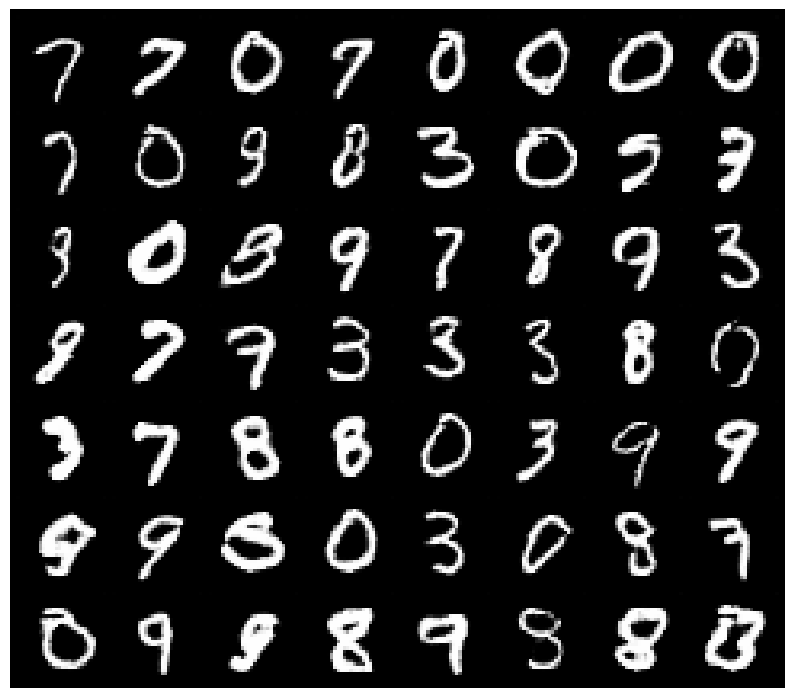

100%|██████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.13it/s, loss_D=0.514, loss_G=1.8]


Epoch [50/100] - LR G: 0.0000655, LR D: 0.0000655
Epoch [50/100] - Average D loss: 0.6460, Average G loss: 2.0118


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.93it/s, loss_D=0.618, loss_G=1.87]


Epoch [51/100] - LR G: 0.0000655, LR D: 0.0000655
Epoch [51/100] - Average D loss: 0.6432, Average G loss: 2.0109


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.93it/s, loss_D=0.714, loss_G=1.54]


Epoch [52/100] - LR G: 0.0000655, LR D: 0.0000655
Epoch [52/100] - Average D loss: 0.6525, Average G loss: 1.9813


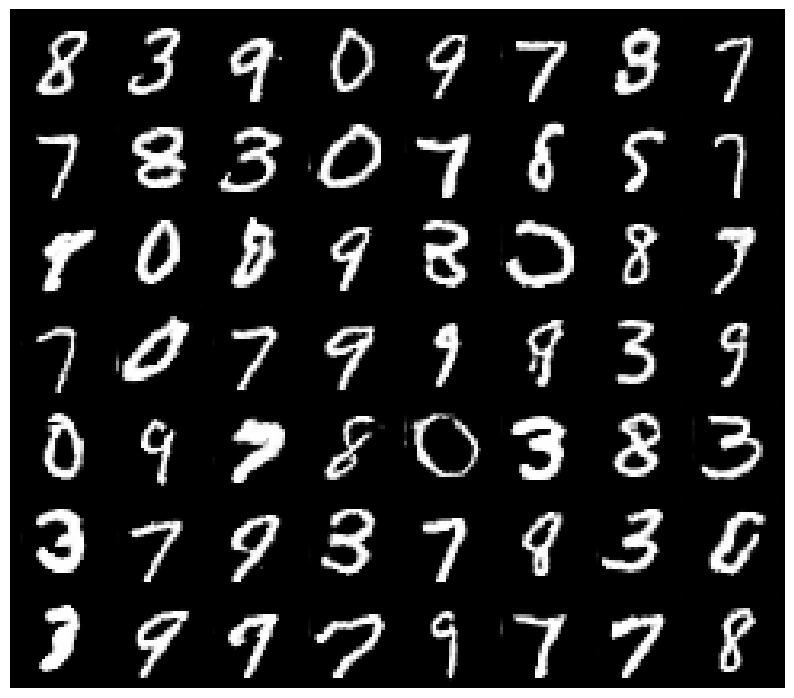

100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.87it/s, loss_D=0.617, loss_G=2.3]


Epoch [53/100] - LR G: 0.0000655, LR D: 0.0000655
Epoch [53/100] - Average D loss: 0.6503, Average G loss: 1.9903


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.86it/s, loss_D=0.64, loss_G=1.87]


Epoch [54/100] - LR G: 0.0000655, LR D: 0.0000655
Epoch [54/100] - Average D loss: 0.6507, Average G loss: 1.9871


100%|████████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.10it/s, loss_D=0.612, loss_G=2]


Epoch [55/100] - LR G: 0.0000655, LR D: 0.0000655
Epoch [55/100] - Average D loss: 0.6503, Average G loss: 1.9813


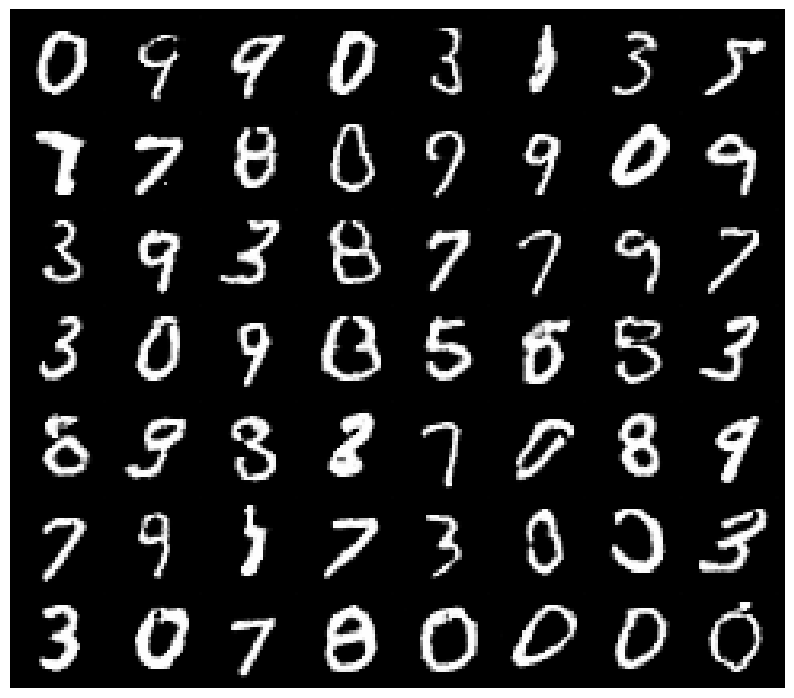

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.22it/s, loss_D=0.733, loss_G=1.93]


Epoch [56/100] - LR G: 0.0000655, LR D: 0.0000655
Epoch [56/100] - Average D loss: 0.6452, Average G loss: 1.9946


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.33it/s, loss_D=0.628, loss_G=1.85]


Epoch [57/100] - LR G: 0.0000655, LR D: 0.0000655
Epoch [57/100] - Average D loss: 0.6493, Average G loss: 1.9842


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.21it/s, loss_D=0.607, loss_G=2.12]


Epoch [58/100] - LR G: 0.0000655, LR D: 0.0000655
Epoch [58/100] - Average D loss: 0.6503, Average G loss: 1.9888


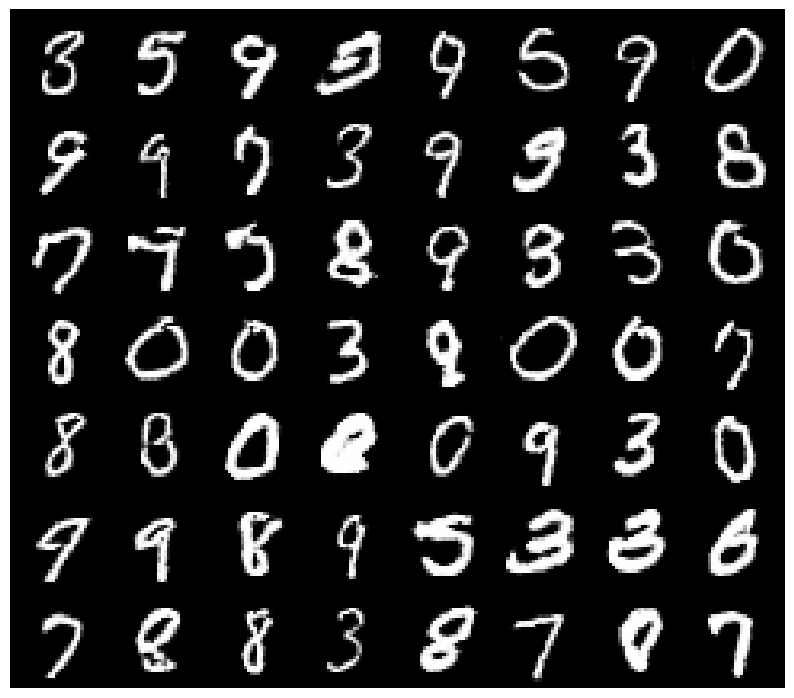

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.27it/s, loss_D=0.456, loss_G=2.35]


Epoch [59/100] - LR G: 0.0000655, LR D: 0.0000655
Epoch [59/100] - Average D loss: 0.6481, Average G loss: 1.9890


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.15it/s, loss_D=0.708, loss_G=1.86]


Epoch [60/100] - LR G: 0.0000524, LR D: 0.0000524
Epoch [60/100] - Average D loss: 0.6548, Average G loss: 1.9750


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.05it/s, loss_D=0.632, loss_G=2.09]


Epoch [61/100] - LR G: 0.0000524, LR D: 0.0000524
Epoch [61/100] - Average D loss: 0.6472, Average G loss: 1.9798


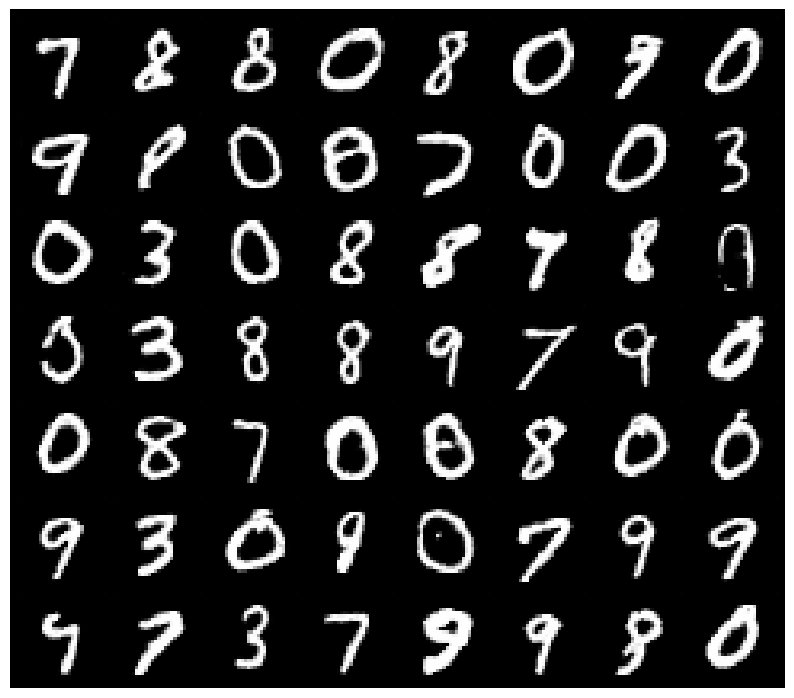

100%|█████████████████████████████████████████████████████| 732/732 [00:50<00:00, 14.38it/s, loss_D=0.605, loss_G=2.04]


Epoch [62/100] - LR G: 0.0000524, LR D: 0.0000524
Epoch [62/100] - Average D loss: 0.6489, Average G loss: 1.9776


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.23it/s, loss_D=0.941, loss_G=1.76]


Epoch [63/100] - LR G: 0.0000524, LR D: 0.0000524
Epoch [63/100] - Average D loss: 0.6494, Average G loss: 1.9690


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.20it/s, loss_D=0.829, loss_G=1.69]


Epoch [64/100] - LR G: 0.0000524, LR D: 0.0000524
Epoch [64/100] - Average D loss: 0.6513, Average G loss: 1.9672


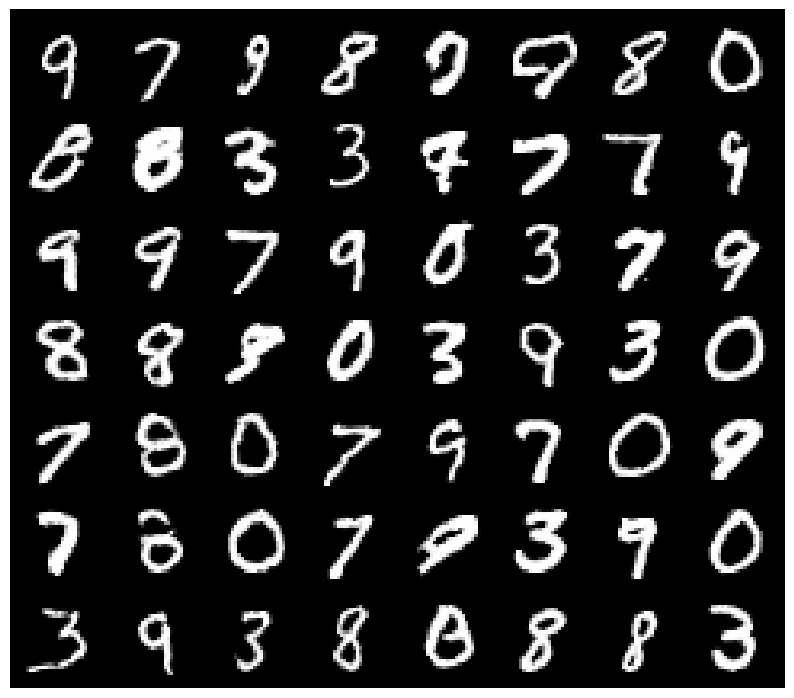

100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.90it/s, loss_D=0.61, loss_G=1.89]


Epoch [65/100] - LR G: 0.0000524, LR D: 0.0000524
Epoch [65/100] - Average D loss: 0.6516, Average G loss: 1.9723


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.18it/s, loss_D=0.771, loss_G=2.02]


Epoch [66/100] - LR G: 0.0000524, LR D: 0.0000524
Epoch [66/100] - Average D loss: 0.6479, Average G loss: 1.9836


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.25it/s, loss_D=0.698, loss_G=1.87]


Epoch [67/100] - LR G: 0.0000524, LR D: 0.0000524
Epoch [67/100] - Average D loss: 0.6508, Average G loss: 1.9652


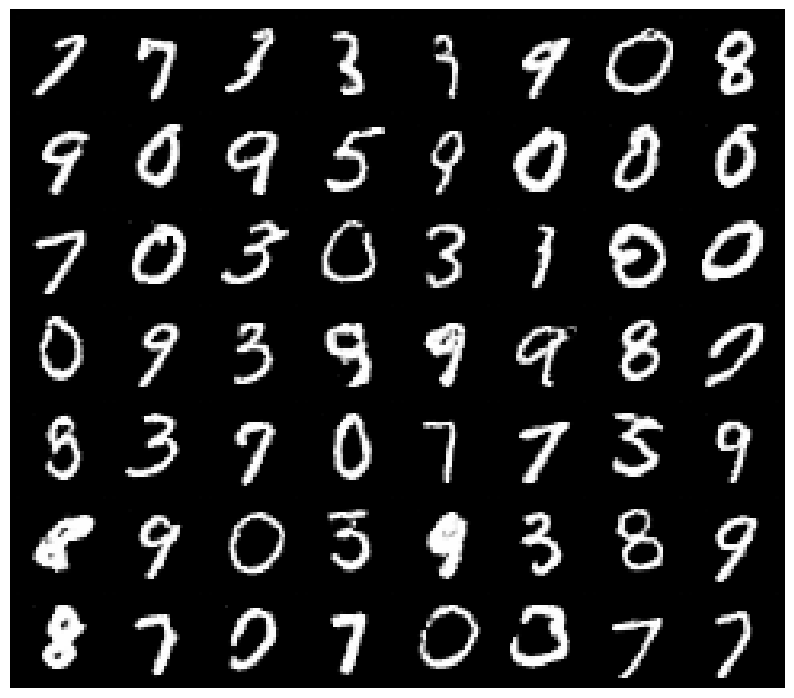

100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.93it/s, loss_D=0.62, loss_G=1.97]


Epoch [68/100] - LR G: 0.0000524, LR D: 0.0000524
Epoch [68/100] - Average D loss: 0.6463, Average G loss: 1.9748


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.96it/s, loss_D=0.566, loss_G=1.99]


Epoch [69/100] - LR G: 0.0000524, LR D: 0.0000524
Epoch [69/100] - Average D loss: 0.6491, Average G loss: 1.9660


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.03it/s, loss_D=0.922, loss_G=1.76]


Epoch [70/100] - LR G: 0.0000419, LR D: 0.0000419
Epoch [70/100] - Average D loss: 0.6485, Average G loss: 1.9619


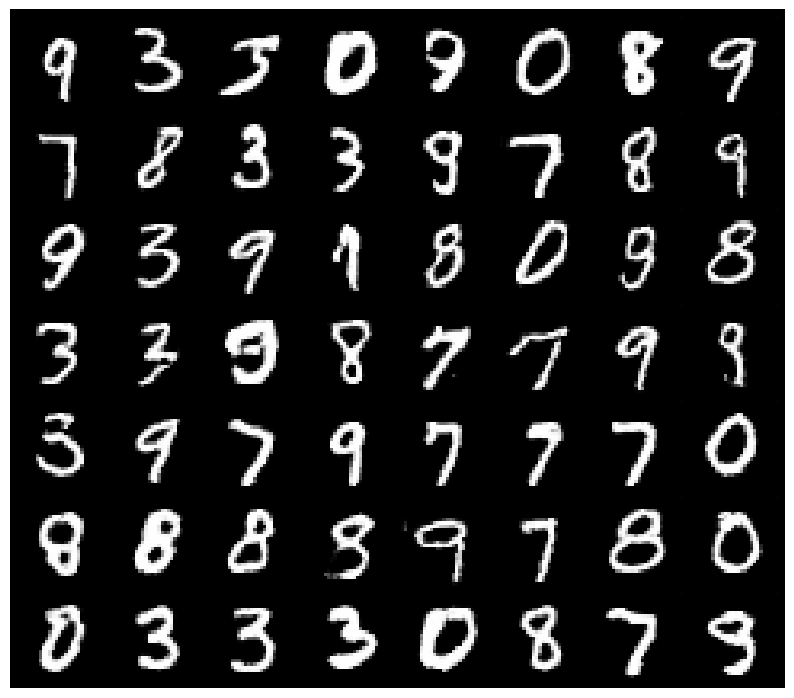

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.02it/s, loss_D=0.636, loss_G=1.81]


Epoch [71/100] - LR G: 0.0000419, LR D: 0.0000419
Epoch [71/100] - Average D loss: 0.6464, Average G loss: 1.9666


100%|█████████████████████████████████████████████████████| 732/732 [03:30<00:00,  3.48it/s, loss_D=0.764, loss_G=2.07]


Epoch [72/100] - LR G: 0.0000419, LR D: 0.0000419
Epoch [72/100] - Average D loss: 0.6448, Average G loss: 1.9710


100%|████████████████████████████████████████████████████████| 732/732 [00:43<00:00, 16.78it/s, loss_D=0.563, loss_G=2]


Epoch [73/100] - LR G: 0.0000419, LR D: 0.0000419
Epoch [73/100] - Average D loss: 0.6468, Average G loss: 1.9608


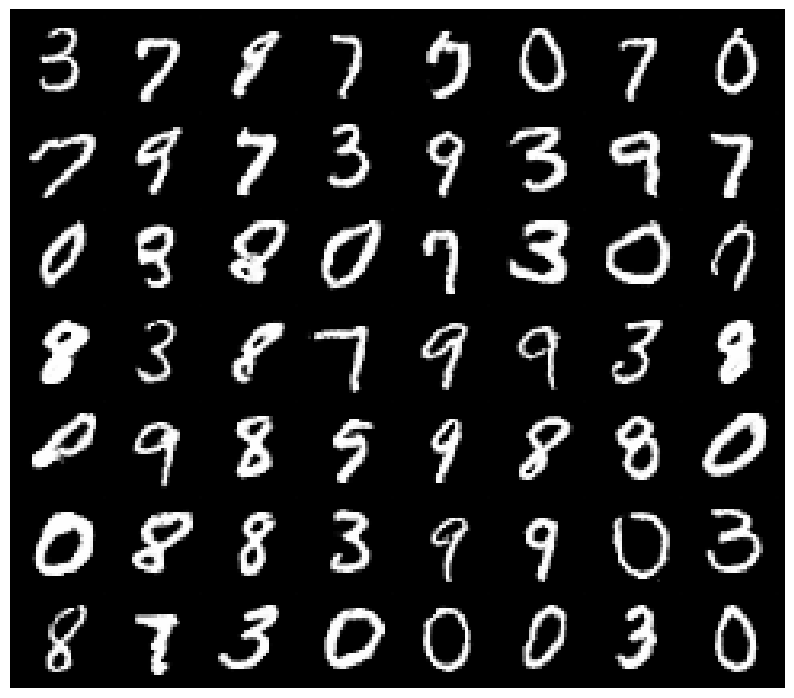

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 31.97it/s, loss_D=0.719, loss_G=1.83]


Epoch [74/100] - LR G: 0.0000419, LR D: 0.0000419
Epoch [74/100] - Average D loss: 0.6452, Average G loss: 1.9531


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 31.98it/s, loss_D=0.532, loss_G=1.95]


Epoch [75/100] - LR G: 0.0000419, LR D: 0.0000419
Epoch [75/100] - Average D loss: 0.6437, Average G loss: 1.9726


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.23it/s, loss_D=0.495, loss_G=1.89]


Epoch [76/100] - LR G: 0.0000419, LR D: 0.0000419
Epoch [76/100] - Average D loss: 0.6465, Average G loss: 1.9685


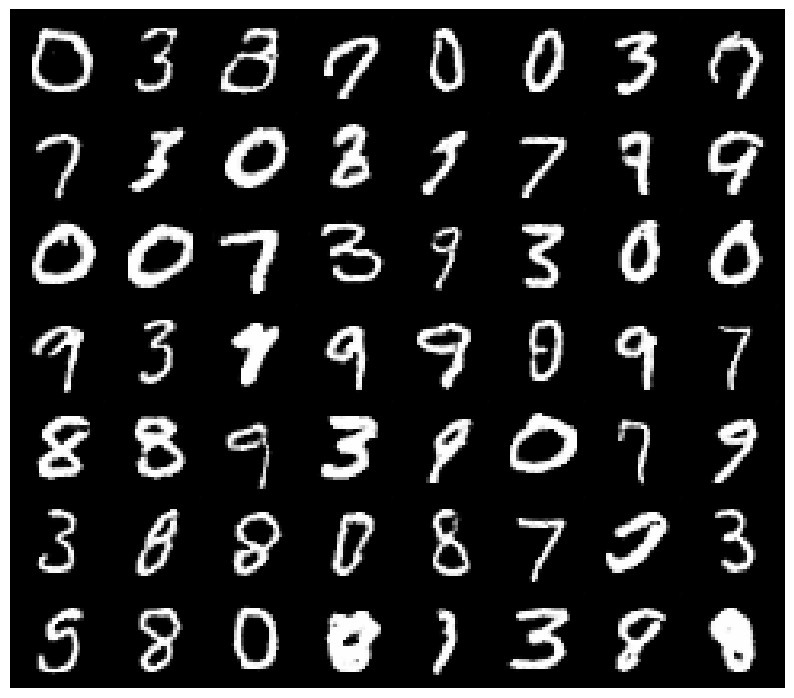

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.33it/s, loss_D=0.671, loss_G=1.85]


Epoch [77/100] - LR G: 0.0000419, LR D: 0.0000419
Epoch [77/100] - Average D loss: 0.6440, Average G loss: 1.9712


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.56it/s, loss_D=0.678, loss_G=2.09]


Epoch [78/100] - LR G: 0.0000419, LR D: 0.0000419
Epoch [78/100] - Average D loss: 0.6478, Average G loss: 1.9575


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.55it/s, loss_D=0.683, loss_G=1.71]


Epoch [79/100] - LR G: 0.0000419, LR D: 0.0000419
Epoch [79/100] - Average D loss: 0.6456, Average G loss: 1.9594


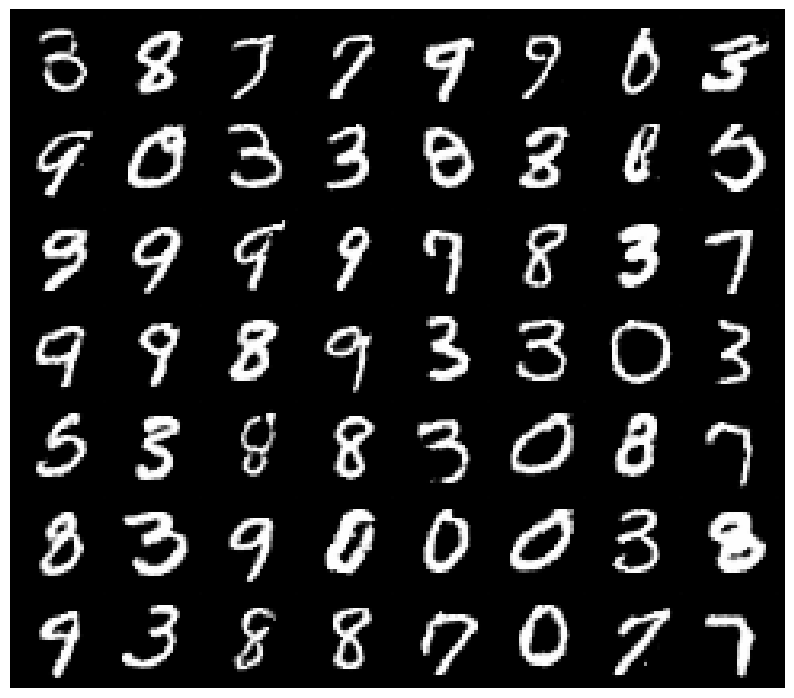

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.36it/s, loss_D=0.717, loss_G=1.88]


Epoch [80/100] - LR G: 0.0000336, LR D: 0.0000336
Epoch [80/100] - Average D loss: 0.6487, Average G loss: 1.9573


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.58it/s, loss_D=0.639, loss_G=1.84]


Epoch [81/100] - LR G: 0.0000336, LR D: 0.0000336
Epoch [81/100] - Average D loss: 0.6483, Average G loss: 1.9618


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.40it/s, loss_D=0.704, loss_G=2.12]


Epoch [82/100] - LR G: 0.0000336, LR D: 0.0000336
Epoch [82/100] - Average D loss: 0.6474, Average G loss: 1.9602


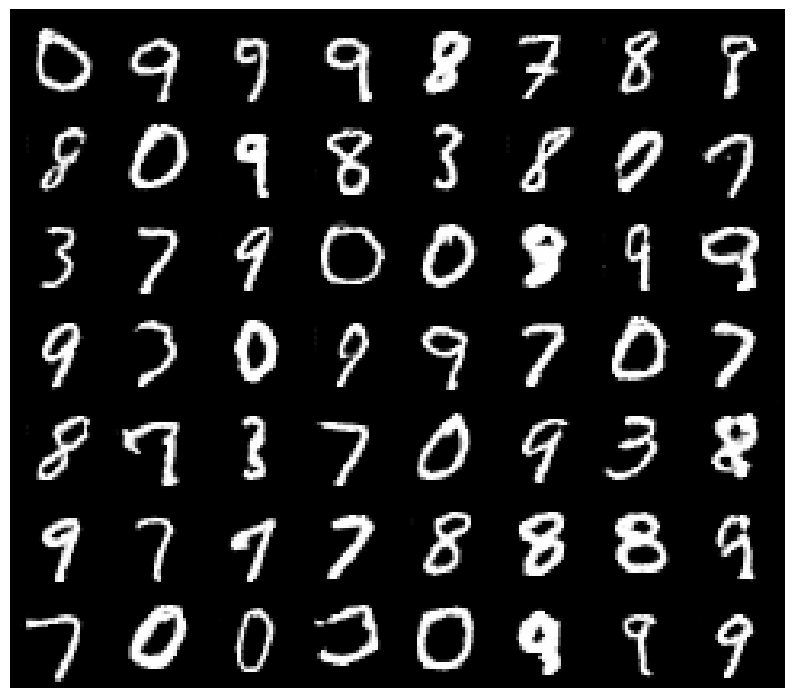

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.29it/s, loss_D=0.612, loss_G=2.03]


Epoch [83/100] - LR G: 0.0000336, LR D: 0.0000336
Epoch [83/100] - Average D loss: 0.6468, Average G loss: 1.9478


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.54it/s, loss_D=0.529, loss_G=2.12]


Epoch [84/100] - LR G: 0.0000336, LR D: 0.0000336
Epoch [84/100] - Average D loss: 0.6397, Average G loss: 1.9712


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.54it/s, loss_D=0.769, loss_G=2.07]


Epoch [85/100] - LR G: 0.0000336, LR D: 0.0000336
Epoch [85/100] - Average D loss: 0.6423, Average G loss: 1.9564


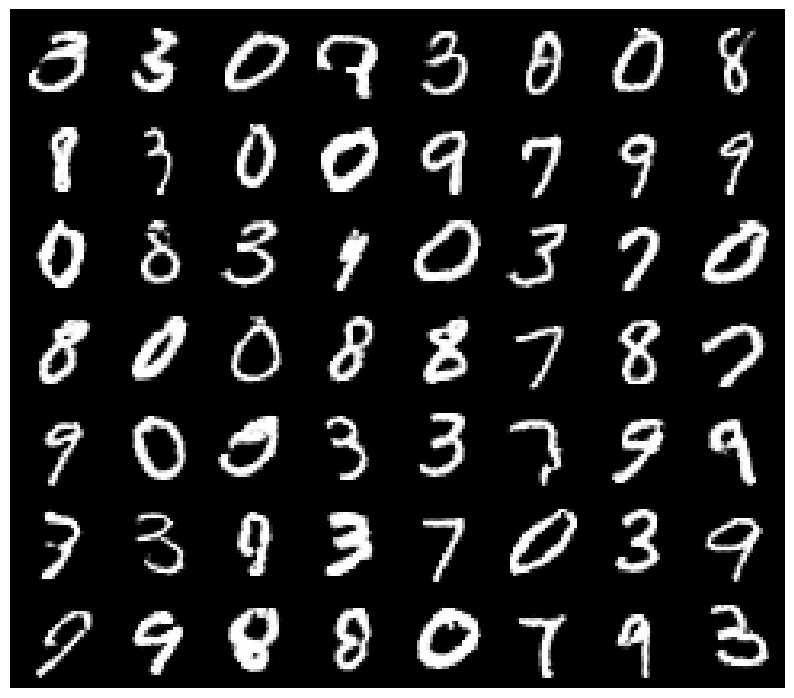

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.51it/s, loss_D=0.799, loss_G=1.73]


Epoch [86/100] - LR G: 0.0000336, LR D: 0.0000336
Epoch [86/100] - Average D loss: 0.6474, Average G loss: 1.9564


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.55it/s, loss_D=0.613, loss_G=1.83]


Epoch [87/100] - LR G: 0.0000336, LR D: 0.0000336
Epoch [87/100] - Average D loss: 0.6431, Average G loss: 1.9653


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.52it/s, loss_D=0.551, loss_G=1.92]


Epoch [88/100] - LR G: 0.0000336, LR D: 0.0000336
Epoch [88/100] - Average D loss: 0.6420, Average G loss: 1.9632


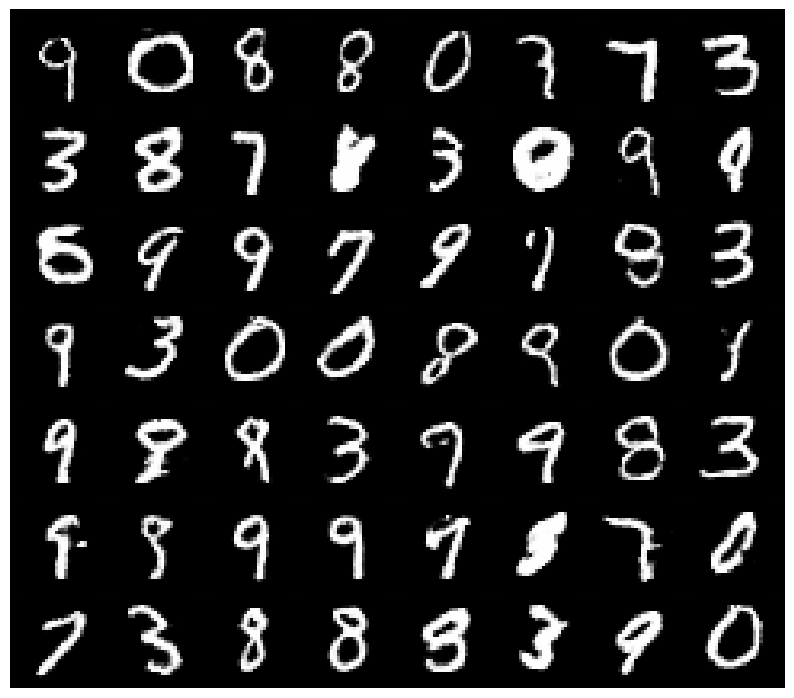

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.55it/s, loss_D=0.536, loss_G=1.82]


Epoch [89/100] - LR G: 0.0000336, LR D: 0.0000336
Epoch [89/100] - Average D loss: 0.6439, Average G loss: 1.9610


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.50it/s, loss_D=0.663, loss_G=2.01]


Epoch [90/100] - LR G: 0.0000268, LR D: 0.0000268
Epoch [90/100] - Average D loss: 0.6404, Average G loss: 1.9751


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.64it/s, loss_D=0.67, loss_G=1.79]


Epoch [91/100] - LR G: 0.0000268, LR D: 0.0000268
Epoch [91/100] - Average D loss: 0.6424, Average G loss: 1.9495


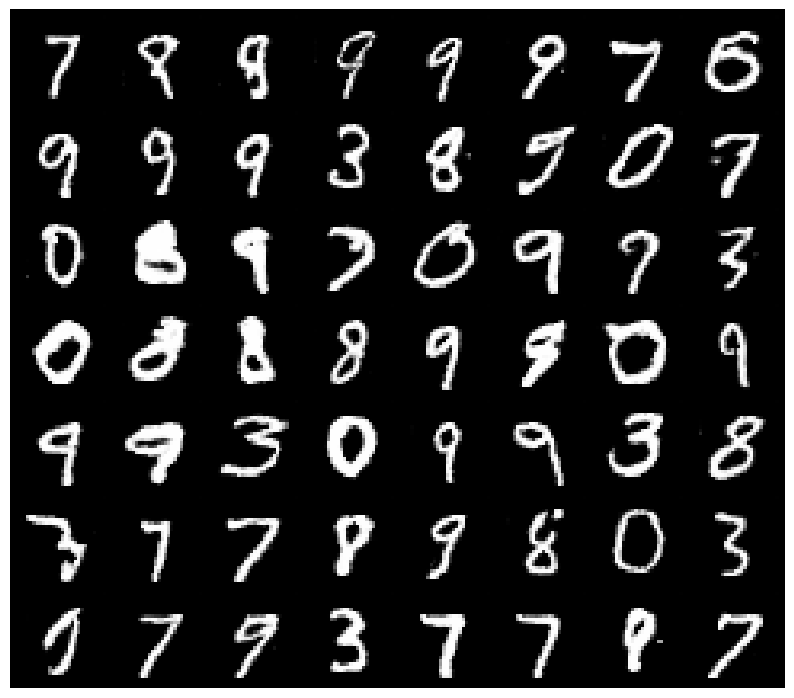

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.55it/s, loss_D=0.544, loss_G=2.22]


Epoch [92/100] - LR G: 0.0000268, LR D: 0.0000268
Epoch [92/100] - Average D loss: 0.6381, Average G loss: 1.9670


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.75it/s, loss_D=0.707, loss_G=1.86]


Epoch [93/100] - LR G: 0.0000268, LR D: 0.0000268
Epoch [93/100] - Average D loss: 0.6374, Average G loss: 1.9769


100%|█████████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.39it/s, loss_D=0.61, loss_G=2]


Epoch [94/100] - LR G: 0.0000268, LR D: 0.0000268
Epoch [94/100] - Average D loss: 0.6391, Average G loss: 1.9655


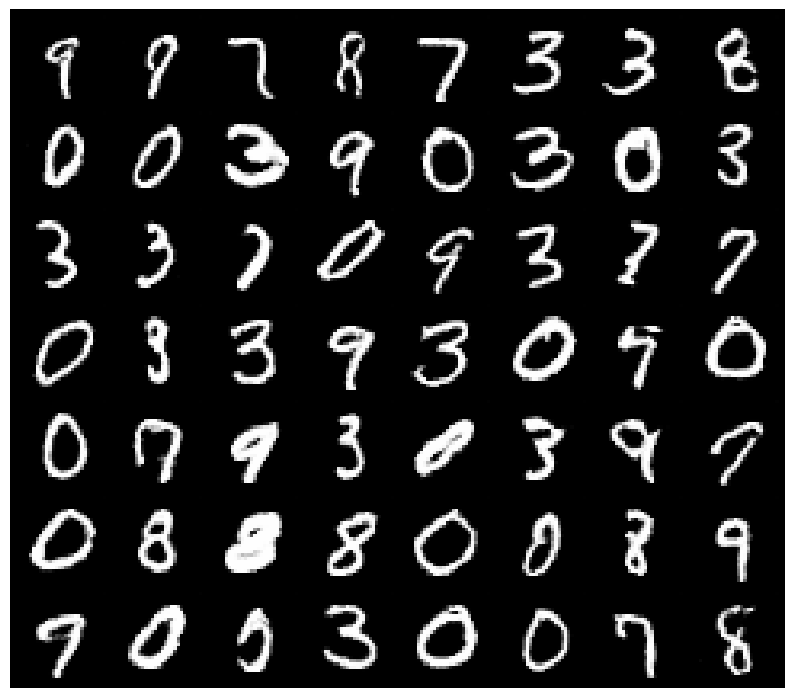

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.74it/s, loss_D=0.701, loss_G=1.89]


Epoch [95/100] - LR G: 0.0000268, LR D: 0.0000268
Epoch [95/100] - Average D loss: 0.6396, Average G loss: 1.9649


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.41it/s, loss_D=0.515, loss_G=2.05]


Epoch [96/100] - LR G: 0.0000268, LR D: 0.0000268
Epoch [96/100] - Average D loss: 0.6405, Average G loss: 1.9581


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.41it/s, loss_D=0.489, loss_G=2.16]


Epoch [97/100] - LR G: 0.0000268, LR D: 0.0000268
Epoch [97/100] - Average D loss: 0.6427, Average G loss: 1.9585


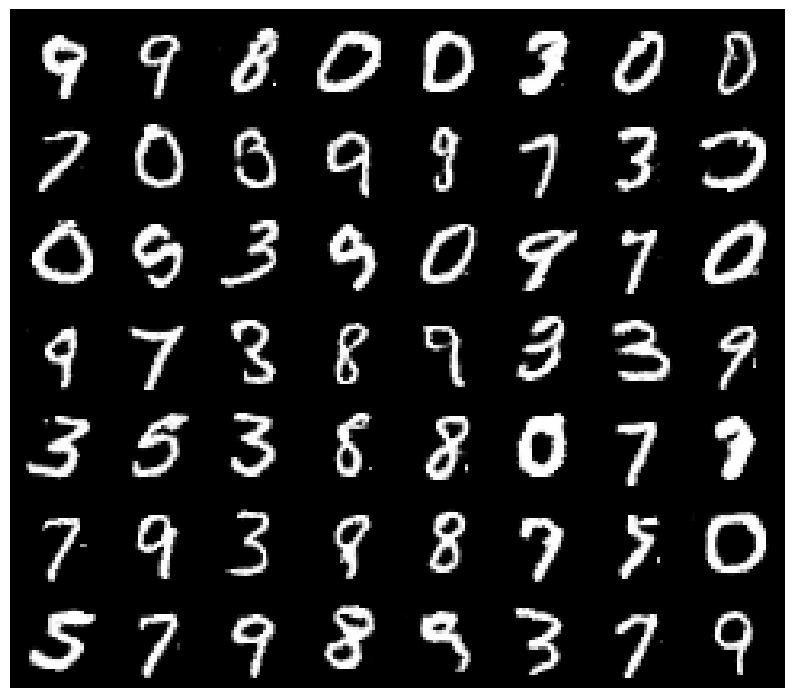

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.70it/s, loss_D=0.568, loss_G=2.32]


Epoch [98/100] - LR G: 0.0000268, LR D: 0.0000268
Epoch [98/100] - Average D loss: 0.6343, Average G loss: 1.9776


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.51it/s, loss_D=0.596, loss_G=2.1]


Epoch [99/100] - LR G: 0.0000268, LR D: 0.0000268
Epoch [99/100] - Average D loss: 0.6408, Average G loss: 1.9644


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.53it/s, loss_D=0.896, loss_G=1.86]


Epoch [100/100] - LR G: 0.0000215, LR D: 0.0000215
Epoch [100/100] - Average D loss: 0.6364, Average G loss: 1.9728


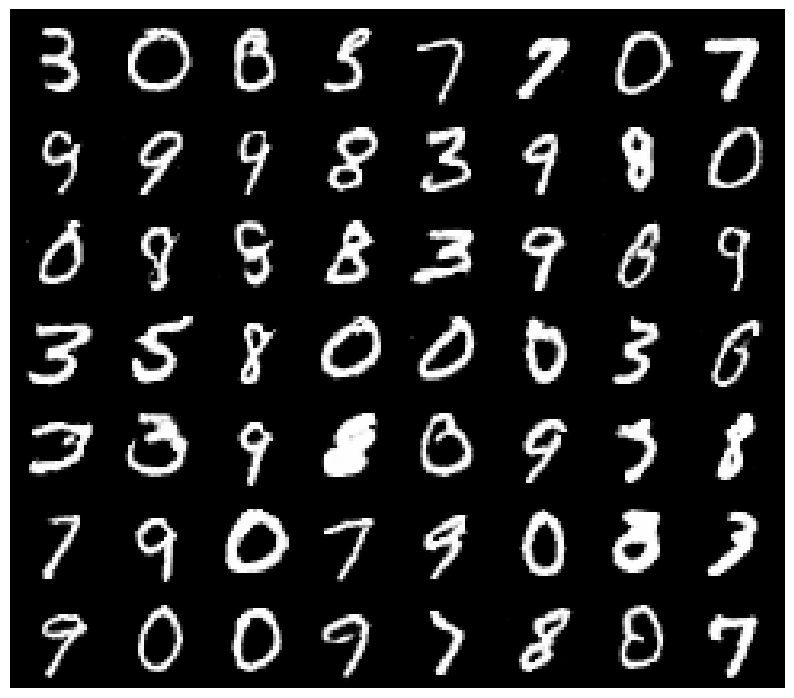

In [15]:
def preprocess_images(images):
    normalized_images = (generated_images + 1) / 2
    display_images = (normalized_images * 255).type(torch.uint8)
    return display_images

# Initialize variables
min_g_loss = float('inf')
epochs = 100
average_d_losses = []  # List to store average discriminator losses per epoch
average_g_losses = []  # List to store average generator losses per epoch

# Assume definitions of loader_discriminator, discriminator, generator, optim_D, and optim_G

for epoch in range(epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0
    count_batches = 0

    loop = tqdm(loader_discriminator, leave=True, total=len(loader_discriminator))
    for real_imgs, _ in loop:
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        optim_D.zero_grad()
        real_preds = discriminator(real_imgs)
        real_loss = F.binary_cross_entropy(real_preds, real_labels)

        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_imgs = generator(noise)
        fake_preds = discriminator(fake_imgs.detach())
        fake_loss = F.binary_cross_entropy(fake_preds, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optim_D.step()

        optim_G.zero_grad()
        tricked_preds = discriminator(fake_imgs)
        g_loss = F.binary_cross_entropy(tricked_preds, real_labels)
        g_loss.backward()
        optim_G.step()

        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()
        count_batches += 1

        loop.set_postfix(loss_D=d_loss.item(), loss_G=g_loss.item())

    avg_d_loss = total_d_loss / count_batches
    avg_g_loss = total_g_loss / count_batches

    average_d_losses.append(avg_d_loss)
    average_g_losses.append(avg_g_loss)

    scheduler_G.step()
    scheduler_D.step()

    lr_G = optim_G.param_groups[0]['lr']
    lr_D = optim_D.param_groups[0]['lr']

    # Print current learning rates
    print(f"Epoch [{epoch + 1}/{epochs}] - LR G: {lr_G:.7f}, LR D: {lr_D:.7f}")
    print(f"Epoch [{epoch + 1}/{epochs}] - Average D loss: {avg_d_loss:.4f}, Average G loss: {avg_g_loss:.4f}")

    if epoch % 3 == 0:
        with torch.no_grad():
            test_noise = torch.randn(batch_size, noise_dim).to(device)
            generated_images = generator(test_noise)
            generated_images = preprocess_images(generated_images)

            plt.figure(figsize=(10, 10))
            grid = make_grid(generated_images, nrow=8)
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.axis('off')
            plt.show()

torch.save(generator.state_dict(), 'best_generator.pth')

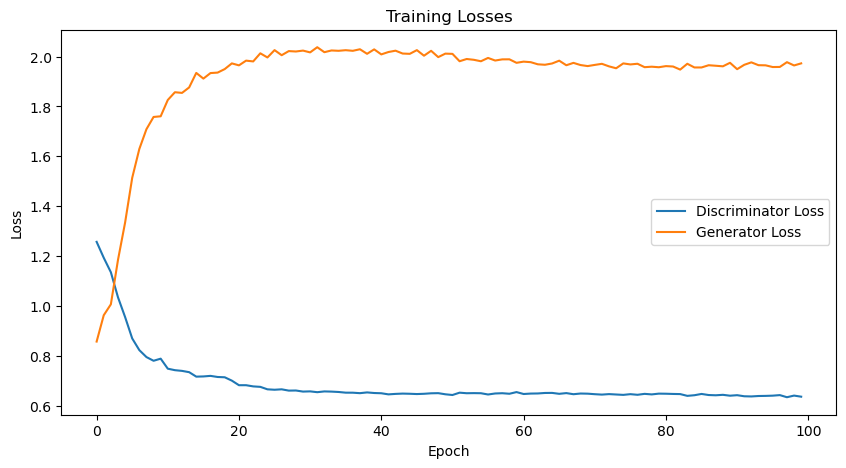

In [16]:
# Plotting the training losses
plt.figure(figsize=(10, 5))
plt.plot(average_d_losses, label='Discriminator Loss')
plt.plot(average_g_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
def calculate_transposed_conv_output_size(H_in, W_in, K, S, P, O):
    """
    Calculate the output dimensions (height and width) of a transposed convolution layer.

    Parameters:
    H_in (int): Height of the input feature map.
    W_in (int): Width of the input feature map.
    K (int): Kernel size.
    S (int): Stride.
    P (int): Padding applied to the input.
    O (int): Output padding.

    Returns:
    tuple: (H_out, W_out) output height and width.
    """
    H_out = (H_in - 1) * S - 2 * P + K + O
    W_out = (W_in - 1) * S - 2 * P + K + O
    return H_out, W_out

# Example usage with specific parameters
H_in, W_in = 26, 26  # Example input dimensions
K = 3             # Kernel size
S = 1              # Stride
P = 0              # Padding
O = 0              # Output padding

# Calculate output dimensions
output_dims = calculate_transposed_conv_output_size(H_in, W_in, K, S, P, O)
output_dims

(28, 28)

In [18]:
def calculate_conv_output_size(input_size, kernel_size, stride, padding):
    """
    Calculate the output size of a convolutional layer.

    Args:
    input_size (tuple): The height and width of the input image (height, width).
    kernel_size (int): The size of the kernel/filter.
    stride (int): The stride of the convolution operation.
    padding (int): The padding added to the input image.

    Returns:
    tuple: The height and width of the output image (height, width).
    """
    input_height, input_width = input_size

    output_height = (input_height + 2 * padding - kernel_size) // stride + 1
    output_width = (input_width + 2 * padding - kernel_size) // stride + 1

    return (output_height, output_width)

# Example usage:
input_height = 28  # Example input height
input_width = 28   # Example input width
kernel_size = 3
stride = 2
padding = 2

output_size = calculate_conv_output_size((input_height, input_width), kernel_size, stride, padding)
print("Output size:", output_size)

Output size: (15, 15)


In [19]:
# Load the trained generator weights
generator.load_state_dict(torch.load('best_generator.pth'))
generator.eval()  # Set to evaluation mode

Generator(
  (fc): Linear(in_features=49, out_features=49, bias=True)
  (convT1): ConvTranspose2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT5): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
)

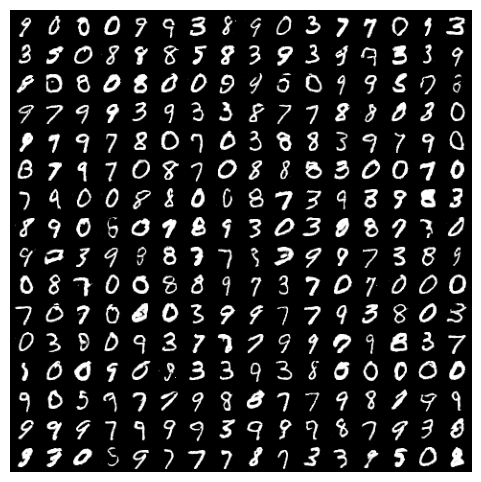

In [20]:
# Generate noise vectors
batch_size = 256  # Number of images to generate
noise = torch.randn(batch_size, noise_dim).to(device)

# Generate images from noise vectors
with torch.no_grad():
    fake_images = generator(noise)

# Assuming images are 28x28 and need to be reshaped
fake_images = fake_images.view(batch_size, 1, 28, 28)  # Reshape images to BxCxHxW format if needed
grid = make_grid(fake_images, nrow=16, normalize=True)  # Create a grid of images

# Visualize images
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())  # Adjust the channel ordering
plt.axis('off')
plt.show()
